# Тематическая модель [Постнауки](http://postnauka.ru)
## Peer Review (optional)

В этом задании мы применим аппарат тематического моделирования к коллекции текстовых записей видеолекций, скачанных с сайта Постнаука. Мы будем визуализировать модель и создавать прототип тематического навигатора по коллекции. В коллекции 1728 документов, размер словаря - 38467 слов. Слова лемматизированы, то есть приведены к начальной форме, с помощью программы [mystem](https://tech.yandex.ru/mystem/), коллекция сохранена в [формате vowpal wabbit](http://docs.bigartm.org/en/latest/formats.html). В каждой строке до первой черты записана информация о документе (ссылка на страницу с лекцией), после первой черты следует описание документа. Используются две модальности - текстовая ("text") и модальность авторов ("author"); у каждого документа один автор.

Для выполнения задания понадобится библиотека [BigARTM](http://docs.bigartm.org). В демонстрации показан пример использования библиотеки версии 0.7.4, на сайте предлагается скачивать версию 0.8.0. В новой версии изменены принципы работы со словарями: они вынесены в отдельный класс (пример в [Release Notes](http://docs.bigartm.org/en/stable/release_notes/python.html)). Строить модель и извлекать ее параметры нужно так же, как показано в демонстрации. Вы можете использовать [предыдущий релиз](http://bigartm.readthedocs.io/en/v0.7.6/download.html) или [новый релиз](http://docs.bigartm.org/en/latest/download.html) на ваше усмотрение.

Спецификации всех функций вы можете смотреть на странице [Python API](http://bigartm.readthedocs.io/en/stable/python_interface.html).

In [1]:
import artm

In [2]:
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline
seaborn.set_style("whitegrid", {'axes.grid' : False})

In [3]:
import numpy as np
import pandas as pd

##### Считывание данных

Создайте объект класса artm.BatchVectorizer, который будет ссылаться на директорию с пакетами данных (батчами). Чтобы библиотека могла преобразовать текстовый файл в батчи, создайте пустую директорию и укажите ее название в параметре target_folder. Размер батча для небольших коллекций (как наша) не важен, вы можете указать любой.

In [4]:
batch_vectorizer = artm.BatchVectorizer(data_path="lectures.txt", data_format="vowpal_wabbit", target_folder="lectures_batches", 
                                       batch_size=100)

##### Инициализация модели

Создайте объект класса artm.Model с 30 темами, именами тем, указанными ниже и единичными весами обеих модальностей. Количество тем выбрано не очень большим, чтобы вам было удобнее работать с темами. На этой коллекции можно строить и большее число тем, тогда они будут более узко специализированы.

In [5]:
T = 30   # количество тем
topic_names=["sbj"+str(i) for i in range(T-1)]+["bcg"]

model_artm = artm.ARTM(num_topics=T, topic_names=topic_names, class_ids={"text":1,"author":2}, 
                       num_document_passes=1, reuse_theta=True, cache_theta=True, seed=1)

Мы будем строить 29 предметных тем и одну фоновую. 

Соберите словарь с помощью метода gather_dictionary и инициализируйте модель, указав random_seed=1. Обязательно укажите свое название словаря, оно понадобится при добавлении регуляризаторов.

In [6]:
dictionary = artm.Dictionary('dictionary')
dictionary.gather(batch_vectorizer.data_path)

In [7]:
model_artm.initialize('dictionary')

##### Добавление score

Создайте два измерителя качества artm.TopTokensScore - по одному для каждой модальности; количество токенов 15. Названия для score придумайте самостоятельно.

In [8]:
model_artm.scores.add(artm.TopTokensScore(name="text_score", num_tokens=15, class_id="text"))
model_artm.scores.add(artm.TopTokensScore(name="authors_score", num_tokens=15, class_id="author"))

##### Построение модели

Мы будем строить модель в два этапа: сначала добавим сглаживающий регуляризатор фоновой темы и настроим параметры модели, затем - добавим разреживающий регуляризатор предметрых тем и выполним еще несколько итераций. Так мы сможем получить наиболее чистые от фоновых слов предметные темы. Сглаживающий и разреживающий регуляризаторы задаются одним и тем же классом artm.SmoothSparsePhiRegularizer: если коэффициент tau положительный, то регуляризатор будет сглаживающий, если отрицательный - разреживающий.

Если вы хотите подробнее разобраться, как выполняется регуляризация тематической модели в BigARTM, вы можете прочитать [статью](https://s3-eu-west-1.amazonaws.com/artm/voron-potap14artm-rus.pdf), раздел 4.

Добавьте сглаживающий регуляризатор с коэффициентом tau = 1e5, указав название своего словаря в dictionary, модальность текста в class_ids и тему "bcg" в topic_names.

In [9]:
model_artm.regularizers.add(
    artm.SmoothSparsePhiRegularizer(
        dictionary=dictionary, topic_names=["bcg"], class_ids=["text"], tau=1e5
    )
)

Выполните 30 итераций по коллекции (num_collection_passes), количество внутренних итераций установите равным 1. Используйте метод fit_offline модели.

In [10]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30)

Добавьте разреживающий регуляризатор с коэффициентом tau=-1e5, указав название своего словаря, модальность текста в class_ids и все темы "sbjX" в topic_names.

In [11]:
model_artm.regularizers.add(
    artm.SmoothSparsePhiRegularizer(
        dictionary=dictionary, topic_names=topic_names[:-1], class_ids=["text"], tau=-1e5
    )
)

Выполните еще 15 проходов по коллекции.

In [12]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

##### Интерпретация тем

Используя созданные score, выведите топы слов и топы авторов в темах. Удобнее всего выводить топ слов каждой темы с новой строки, указывая название темы в начале строки, и аналогично с авторами.

In [13]:
for topic_name in model_artm.topic_names:
    print '%s: %s' % (topic_name, ','.join( model_artm.score_tracker['text_score'].last_tokens[topic_name] ) )

sbj0: частица,взаимодействие,физика,кварк,симметрия,элементарный,нейтрино,стандартный,материя,протон,бозон,масса,заряд,ускоритель,слабый
sbj1: материал,температура,структура,вещество,химический,соединение,свойство,поверхность,химия,давление,углерод,сверхпроводимость,металл,применение,полимер
sbj2: политический,государство,политика,царь,партия,власть,правитель,враг,сага,кризис,ритуал,шмитт,государь,средневековый,египетский
sbj3: университет,школа,образование,предмет,познание,знание,факультет,аргумент,студент,логика,кафедра,восприятие,концепт,учитель,прикладной
sbj4: мозг,ребенок,нейрон,мышление,предложение,категория,взрослый,чтение,лицо,синтаксический,синтаксис,обезьяна,детство,словосочетание,шимпанзе
sbj5: бог,миф,греческий,герой,море,мифология,грек,мифологический,гусейнов,божество,персонаж,шумерский,гасан,генеалогия,сущность
sbj6: русский,город,текст,городской,перевод,корпус,гласный,говор,москва,пьеса,горожанин,документ,немецкий,древнерусский,метро
sbj7: раса,трудность,праздник,шаман,

В последней теме "bcg" должны находиться общеупотребительные слова.

Важный шаг в работе с тематической моделью, когда речь идет о визуализации или создании тематического навигатора, это именование тем. Понять, о чем каждая тема, можно по списку ее топовых слов. Например, тему
    
    частица взаимодействие физика кварк симметрия элементарный нейтрино стандартный материя протон бозон заряд масса ускоритель слабый
    
можно назвать "Физика элементарных частиц". 

Дайте названия 29 предметным темам. Если вы не знаете, как назвать тему, назовите ее первым встретившимся в ней существительным, хотя при таком подходе навигатор будет менее информативным. Из названий тем составьте список из 29 строк и запишите го в переменную sbj_topic_labels. В переменной topic_labels будут храниться названия всех тем, включая фоновую.

In [14]:
sbj_topic_labels = [
    "Физика элементарных частиц",
    "Химия",
    "История",
    "Образование",
    "Мозг",
    "Мифология",
    "Россия",
    "Антропогенез",
    "Юриспруденция",
    "Медицина",
    "Биология",
    "Нейробиология",
    "История России",
    "Социология",
    "Астрономия",
    "Экономика",
    "Психология",
    "Информатика",
    "История Востока",
    "Генетика",
    "Физика",
    "Философия",
    "Всемирная история",
    "Советский Союз",
    "Лингвистика",
    "Математика",
    "Актерское мастерство",
    "Астрофизика",
    "Культура"
]
topic_labels = sbj_topic_labels + ["Фоновая тема"]

##### Анализ тем

Далее мы будем работать с распределениями тем в документах (матрица $\Theta$) и авторов в темах (одна из двух матриц $\Phi$, соответствующая модальности авторов). 
Создайте переменные, содержащие две этих матрицы, с помощью методов get_phi и get_theta модели. Назовите переменные theta и phi_a. Выведите формы обеих матриц, чтобы понять, по каким осям стоят темы.

In [15]:
model_artm.theta_columns_naming = "title" # включает именование столбцов Theta их названиями-ссылками, а не внутренними id 

theta = model_artm.get_theta()
phi_a = model_artm.get_phi(class_ids=['author'])

theta.shape, phi_a.shape

((30, 1728), (539, 30))

Визуализируем фрагмент матрицы $\Theta$ - первые 100 документов (это наиболее простой способ визуально оценить, как темы распределяются в документах). С помощью метода seaborn.heatmap выведите фрагмент theta как изображение. Рекомендация: создайте фигуру pyplot размера (20, 10).

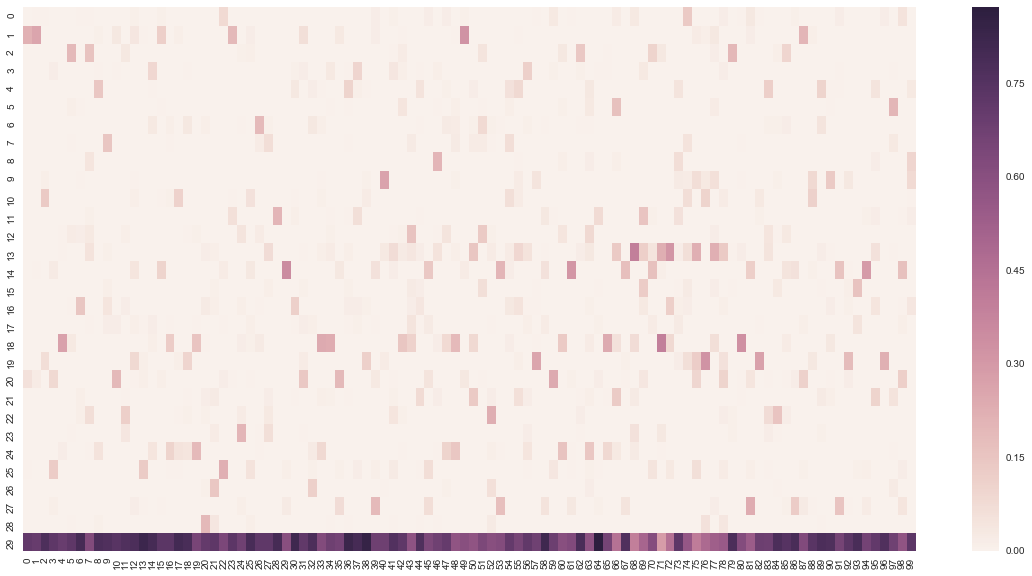

In [16]:
plt.figure(figsize=(20,10))
seaborn.heatmap(theta.as_matrix()[:, :100])

Вы должны увидеть, что фоновая тема имеет большую вероятность в почти каждом документе, и это логично. Кроме того, есть еще одна тема, которая чаще других встречается в документах. Судя по всему, это тема содержит много слов по науку в целом, а каждый документ (видео) в нашей коллекции связан с наукой. Можно (необязательно) дать этой теме название "Наука".

Помимо этих двух тем, фоновой и общенаучной, каждый документ характеризуется малым числом других тем.

Оценим $p(t)$ - долю каждой темы во всей коллекции. По формуле полной вероятности вычислять эти величины нужно как
$p(t) = \sum_d p(t|d) p(d)$. Согласно вероятностной модели, $p(d)$ пропорционально длине документа d. Поступим проще: будем полагать, что все документы равновероятны. Тогда оценить $p(t)$ можно, просуммировав $p(t|d)$ по всем документам, а затем разделив полученный вектор на его сумму. 

Создайте переменную-датафрейм с T строками, индексированными названиями тем, и 1 столбцом, содержащим оценки $p(t)$. Выведите датафрейм на печать.

In [17]:
pt_d = np.sum(theta, axis=1)
pt = pt_d / np.sum(pt_d)
dataframe = pd.DataFrame(data=pt.as_matrix(), index=topic_labels, columns=['P'], dtype=float)
print dataframe

                                   P
Физика элементарных частиц  0.009890
Химия                       0.015111
История                     0.009473
Образование                 0.006068
Мозг                        0.006580
Мифология                   0.007071
Россия                      0.007723
Антропогенез                0.004847
Юриспруденция               0.008321
Медицина                    0.011158
Биология                    0.015278
Нейробиология               0.006900
История России              0.014948
Социология                  0.045560
Астрономия                  0.015070
Экономика                   0.008806
Психология                  0.011108
Информатика                 0.009825
История Востока             0.014995
Генетика                    0.021931
Физика                      0.016981
Философия                   0.014241
Всемирная история           0.008902
Советский Союз              0.006405
Лингвистика                 0.015080
Математика                  0.009296
А

Найдите 5 самых распространенных и 3 наименее освещенных темы в коллекции (наибольшие и наименьшие $p(t)$ соответственно), не считая фоновую и общенаучную. Укажите названия, которые вы дали этим темам.

In [18]:
sorted_dataframe = dataframe.sort_values(by='P')
print sorted_dataframe[:3]
print sorted_dataframe[-6:-1]

                             P
Актерское мастерство  0.003137
Антропогенез          0.004847
Образование           0.006068
                   P
Химия       0.015111
Биология    0.015278
Физика      0.016981
Генетика    0.021931
Социология  0.045560


Визуализируйте матрицу $\Phi$ модальности авторов в виде изображения. Рекомендация: установите yticklabels=False в heatmap.

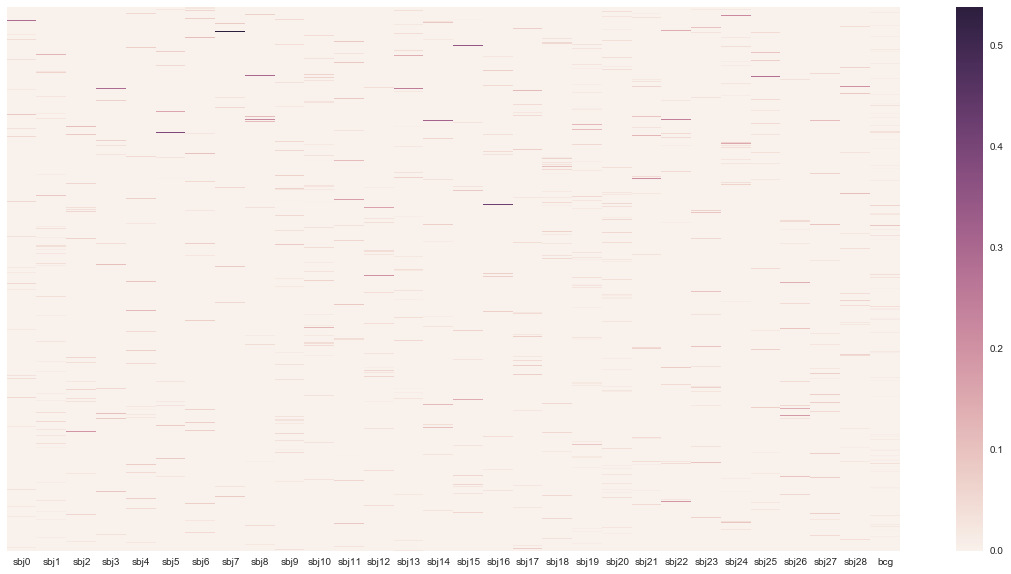

In [19]:
plt.figure(figsize=(20, 10))
seaborn.heatmap(phi_a, yticklabels=False)

Каждой теме соответствует не очень большое число авторов - матрица достаточно разреженная. Кроме того, некоторые темы имеют доминирующего автора $a$, имеющего большую вероятность $p(a|t)$ - этот автор записал больше всего лекций по теме. 

Будем считать, что автор $a$ значим в теме, если $p(a|t) > 0.01$. Для каждого автора посчитайте, в скольких темах он значим. Найдите авторов-рекордсменов, которые значимы (а значит, читали лекции) в >= 3 темах.

In [20]:
most_popular_authors = np.sum(phi_a > 0.01, axis=1)
print "Самые популярные авторы:"
most_popular_authors[most_popular_authors >= 3]

Самые популярные авторы:


Олег_Ауров            3
Александр_Филиппов    3
Илья_Иткин            3
Фёдор_Успенский       3
Александр_Пиперски    4
Николай_Дронин        3
Андрей_Журавлев       3
Ольга_Вайнштейн       3
dtype: int64

Большинство авторов значимы в 1 теме, что логично.

##### Построение тематической карты авторов

По сути, в матрице $\Phi$, соответствующей модальности авторов, записаны тематические кластеры авторов. Для любого автора мы можем составить его тематический круг - авторов, разбирающихся в той же теме, что и данный. Интересующиеся слушатели могут попробовать выполнить эту процедуру для ученых, читающих лекции на Постнауке, которых они знают (например, на Постнауке есть лекции с К. В. Воронцовым - лектором текущего модуля :)

Составим карту близости авторов по тематике их исследований. Для этого применим метод понижения размерности MDS к тематическим профилям авторов.

Чтобы получить тематический профиль автора, распределение $p(t|a)$, нужно воспользоваться формулой Байеса: 
$p(t|a) = \frac {p(a|t) p(t)} {\sum_t' p(a|t') p(t')}$. Все необходимые для этого величины у вас есть и записаны в переменных phi и pt. 

Передайте матрицу тематических профилей авторов, записанных по строкам, в метод MDS с n_components=2. Используйте косинусную метрику (она хорошо подходит для поиска расстояний между векторами, имеющими фиксированную сумму компонент).

In [21]:
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances

In [22]:
profiles = phi_a.values * pt_d.values.T
profiles /= np.sum(profiles)

mds = MDS(dissimilarity="precomputed", n_components=2)
distances = pairwise_distances(profiles, metric = "cosine")
mds_transformed = mds.fit_transform(distances)

Визуализируйте найденные двумерные представления с помощью функции scatter. 

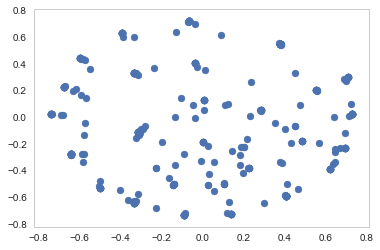

In [23]:
plt.scatter(mds_transformed[0:, 0], mds_transformed[0:, 1])

Должно получиться, что некоторые грппы авторов формируют сгустки, которые можно считать тематическими группами авторов.

Раскрасим точки следующим образом: для каждого автора выберем наиболее вероятную для него тему ($\max_t p(t|a)$), и каждой теме сопоставим цвет. Кроме того, добавим на карту имена и фамилии авторов, это можно сделать в цикле по всем точкам с помощью функции plt.annotate, указывая метку точки первым аргументом и ее координаты в аргументе xy. Рекомендуется сделать размер изображения большим, тогда маркеры точек тоже придется увеличить (s=100 в plt.scatter). Изобразите карту авторов и сохраните в pdf-файл с помощью функции plt.savefig. 

Метки авторов будут пересекаться. Будет очень хорошо, если вы найдете способ, как этого можно избежать.

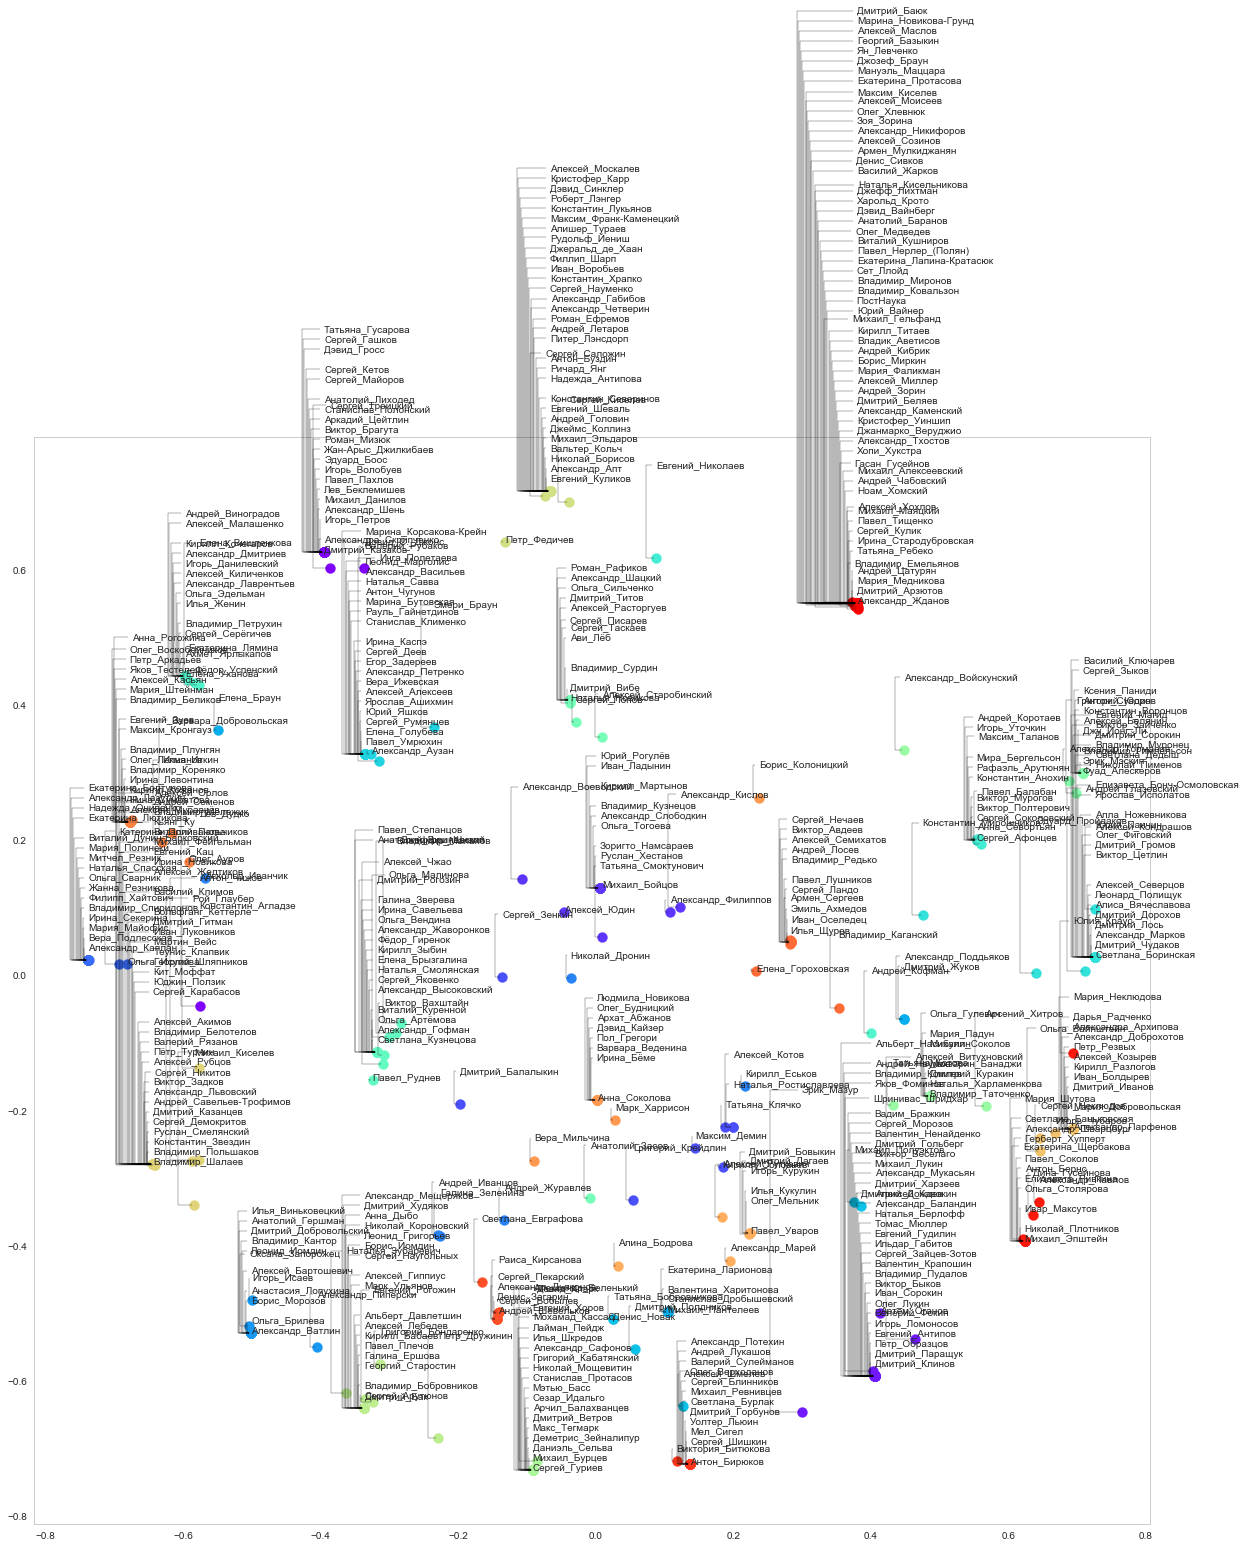

In [24]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, T)) # цвета для тем
figure = plt.figure(figsize=(20, 20))

max_indexes = profiles.argmax(axis=1)
unique_max_indexes = set(max_indexes)

for i, color in zip(unique_max_indexes, colors):
    coord = (i==max_indexes)
    
    plt.scatter(mds_transformed[coord, 0], mds_transformed[coord, 1], c=color, s=100)
    
    for i, (name, xy) in enumerate(zip(phi_a[coord].index, mds_transformed[coord])):
        plt.annotate(name, xy=xy, xytext=(0, i * 10),
                     textcoords='offset points',
                     arrowprops={
                         'arrowstyle' : '-',
                         'connectionstyle' : 'bar, angle=-90, fraction=.1'
                     }
        )

plt.savefig('authors.pdf')

##### Создание простого тематического навигатора по Постнауке

Наш тематический навигатор будет для каждой темы показывать ее список слов, а также список релевантных теме документов. 

Нам понадобятся распределения $p(d|t)$. По формуле Байеса $p(d|t) = \frac{p(t|d)p(d)}{\sum_{d'}p(t|d')p(d')}$, но поскольку мы считаем документы равновероятными, достаточно разделить каждую строку $\Theta$ на ее сумму, чтобы оценить распределение. 

Отсортируйте матрицу $p(d|t)$ по убыванию $p(d|t)$ в каждой теме (то есть построчно). Нам понадобятся индексы наиболее вероятных документов в каждой теме, поэтому используйте функцию argmax.

In [25]:
pdt = np.zeros(theta.shape)

for i in range(theta.shape[0]):
    pdt[i] = theta.iloc[i] / sum(theta.iloc[i])
pdt_sorted = pdt.argsort(axis = 1)[:, ::-1][:,:10]

Создавать навигатор мы будем прямо в jupiter notebook: это возможно благодаря тому факту, что при печати ссылки она автоматически превращается в гиперссылку.

In [26]:
print "http://yandex.ru"   # получится кликабельная ссылка

http://yandex.ru


Кроме того, подключив модуль [ipython.core.display](https://ipython.org/ipython-doc/2/api/generated/IPython.core.display.html), можно использовать html-разметку в выводе. Например:

In [27]:
from IPython.core.display import display, HTML
display(HTML(u"<h1>Заголовок</h1>"))   # также <h2>, <h3>
display(HTML(u"<ul><li>Пункт 1</li><li>Пункт 2</li></ul>"))
display(HTML(u'<font color="green">Зеленый!</font>'))
display(HTML(u'<a href="http://yandex.ru">Еще один вариант вывода ссылки</a>'))

В цикле для каждой темы выведите ее заголовок, в следующей строке - топ-10 слов темы, затем в виде списка ссылки на 10 наиболее релевантных (по $p(d|t)$) теме документов. Используйте html-разметку. Творчество приветствуется :)

In [28]:
display(HTML(u'<h2>Тематический навигатор по "Постнауке"</h2>'))

for topic_name, i in zip(model_artm.topic_names[:-1], xrange(T-1)):
    
    display(HTML(u"<h4>%s</h4>" % topic_labels[i].decode('utf-8')))
    display(HTML(u"<h6>Топ-10 слов темы: </h6>"))

    display(HTML(
        ','.join( model_artm.score_tracker["text_score"].last_tokens[topic_name] )
    ))
    
    print '\n'.join(
            map( lambda j: "%s - %.4f" % (theta.columns.values[pdt_sorted[i][j]], pdt[i, pdt_sorted[i][j]]), range(10) )
    )
    

http://postnauka.ru/video/13043 - 0.0233
http://postnauka.ru/video/18870 - 0.0215
http://postnauka.ru/video/2945 - 0.0179
http://postnauka.ru/video/18873 - 0.0177
http://postnauka.ru/video/47950 - 0.0168
http://postnauka.ru/video/11634 - 0.0167
http://postnauka.ru/video/18865 - 0.0155
http://postnauka.ru/video/1894 - 0.0155
http://postnauka.ru/video/478 - 0.0154
http://postnauka.ru/video/14282 - 0.0153


http://postnauka.ru/video/13700 - 0.0139
http://postnauka.ru/video/31182 - 0.0135
http://postnauka.ru/video/57995 - 0.0124
http://postnauka.ru/video/18048 - 0.0117
http://postnauka.ru/video/41686 - 0.0111
http://postnauka.ru/video/51490 - 0.0108
http://postnauka.ru/video/50340 - 0.0107
http://postnauka.ru/video/46379 - 0.0106
http://postnauka.ru/video/13544 - 0.0103
http://postnauka.ru/video/56295 - 0.0100


http://postnauka.ru/video/32906 - 0.0126
http://postnauka.ru/video/32882 - 0.0122
http://postnauka.ru/video/59199 - 0.0120
http://postnauka.ru/video/56304 - 0.0118
http://postnauka.ru/video/7283 - 0.0117
http://postnauka.ru/video/16824 - 0.0115
http://postnauka.ru/video/53228 - 0.0112
http://postnauka.ru/video/9968 - 0.0112
http://postnauka.ru/video/42088 - 0.0112
http://postnauka.ru/video/3418 - 0.0108


http://postnauka.ru/video/2973 - 0.0315
http://postnauka.ru/video/3603 - 0.0189
http://postnauka.ru/video/31198 - 0.0187
http://postnauka.ru/video/35038 - 0.0187
http://postnauka.ru/video/19570 - 0.0179
http://postnauka.ru/video/55533 - 0.0156
http://postnauka.ru/video/49445 - 0.0154
http://postnauka.ru/video/55217 - 0.0145
http://postnauka.ru/video/51350 - 0.0140
http://postnauka.ru/video/50406 - 0.0137


http://postnauka.ru/video/50793 - 0.0208
http://postnauka.ru/video/55068 - 0.0206
http://postnauka.ru/video/12521 - 0.0195
http://postnauka.ru/video/5178 - 0.0181
http://postnauka.ru/video/47548 - 0.0173
http://postnauka.ru/video/26207 - 0.0169
http://postnauka.ru/video/25891 - 0.0157
http://postnauka.ru/video/7767 - 0.0155
http://postnauka.ru/video/7782 - 0.0151
http://postnauka.ru/video/36350 - 0.0141


http://postnauka.ru/video/9997 - 0.0309
http://postnauka.ru/video/43664 - 0.0198
http://postnauka.ru/video/27831 - 0.0176
http://postnauka.ru/video/42796 - 0.0171
http://postnauka.ru/video/47300 - 0.0171
http://postnauka.ru/video/31990 - 0.0167
http://postnauka.ru/video/5999 - 0.0163
http://postnauka.ru/video/21637 - 0.0160
http://postnauka.ru/video/46427 - 0.0160
http://postnauka.ru/video/5181 - 0.0158


http://postnauka.ru/video/13156 - 0.0206
http://postnauka.ru/video/51171 - 0.0175
http://postnauka.ru/video/36810 - 0.0171
http://postnauka.ru/video/24279 - 0.0165
http://postnauka.ru/video/8964 - 0.0155
http://postnauka.ru/video/48112 - 0.0153
http://postnauka.ru/video/24945 - 0.0153
http://postnauka.ru/video/10773 - 0.0146
http://postnauka.ru/video/23470 - 0.0145
http://postnauka.ru/video/47301 - 0.0145


http://postnauka.ru/video/31707 - 0.0323
http://postnauka.ru/video/32898 - 0.0298
http://postnauka.ru/video/37732 - 0.0294
http://postnauka.ru/video/35150 - 0.0279
http://postnauka.ru/video/42707 - 0.0278
http://postnauka.ru/video/15341 - 0.0269
http://postnauka.ru/video/42735 - 0.0250
http://postnauka.ru/video/31675 - 0.0233
http://postnauka.ru/video/17397 - 0.0227
http://postnauka.ru/video/36253 - 0.0210


http://postnauka.ru/video/9299 - 0.0311
http://postnauka.ru/video/34414 - 0.0225
http://postnauka.ru/video/17912 - 0.0223
http://postnauka.ru/video/38009 - 0.0220
http://postnauka.ru/video/31688 - 0.0215
http://postnauka.ru/video/49455 - 0.0213
http://postnauka.ru/video/16822 - 0.0206
http://postnauka.ru/video/17913 - 0.0206
http://postnauka.ru/video/42221 - 0.0204
http://postnauka.ru/video/31666 - 0.0198


http://postnauka.ru/video/13746 - 0.0234
http://postnauka.ru/video/7753 - 0.0186
http://postnauka.ru/video/11361 - 0.0178
http://postnauka.ru/video/532 - 0.0177
http://postnauka.ru/video/2541 - 0.0175
http://postnauka.ru/video/12974 - 0.0172
http://postnauka.ru/video/11850 - 0.0159
http://postnauka.ru/video/49206 - 0.0151
http://postnauka.ru/video/45961 - 0.0146
http://postnauka.ru/video/51384 - 0.0141


http://postnauka.ru/video/9861 - 0.0140
http://postnauka.ru/video/30673 - 0.0129
http://postnauka.ru/video/8953 - 0.0126
http://postnauka.ru/video/32635 - 0.0115
http://postnauka.ru/video/3602 - 0.0114
http://postnauka.ru/video/19071 - 0.0112
http://postnauka.ru/video/25889 - 0.0104
http://postnauka.ru/video/49437 - 0.0097
http://postnauka.ru/video/1899 - 0.0094
http://postnauka.ru/video/7113 - 0.0093


http://postnauka.ru/video/56052 - 0.0202
http://postnauka.ru/video/54916 - 0.0188
http://postnauka.ru/video/12148 - 0.0177
http://postnauka.ru/video/57336 - 0.0172
http://postnauka.ru/video/25267 - 0.0155
http://postnauka.ru/video/3389 - 0.0144
http://postnauka.ru/video/3645 - 0.0140
http://postnauka.ru/video/37979 - 0.0139
http://postnauka.ru/video/53949 - 0.0138
http://postnauka.ru/video/17421 - 0.0137


http://postnauka.ru/video/24034 - 0.0154
http://postnauka.ru/video/3348 - 0.0152
http://postnauka.ru/video/24039 - 0.0140
http://postnauka.ru/video/32637 - 0.0132
http://postnauka.ru/video/19574 - 0.0128
http://postnauka.ru/video/23900 - 0.0118
http://postnauka.ru/video/50668 - 0.0113
http://postnauka.ru/video/3406 - 0.0112
http://postnauka.ru/video/35041 - 0.0111
http://postnauka.ru/video/31183 - 0.0109


http://postnauka.ru/video/10783 - 0.0074
http://postnauka.ru/video/9148 - 0.0066
http://postnauka.ru/video/9870 - 0.0060
http://postnauka.ru/video/17491 - 0.0058
http://postnauka.ru/video/3417 - 0.0056
http://postnauka.ru/video/6380 - 0.0056
http://postnauka.ru/video/3635 - 0.0055
http://postnauka.ru/video/12574 - 0.0055
http://postnauka.ru/video/7541 - 0.0052
http://postnauka.ru/video/5198 - 0.0051


http://postnauka.ru/video/2971 - 0.0173
http://postnauka.ru/video/9835 - 0.0164
http://postnauka.ru/video/31193 - 0.0140
http://postnauka.ru/video/57338 - 0.0135
http://postnauka.ru/video/31695 - 0.0134
http://postnauka.ru/video/36249 - 0.0126
http://postnauka.ru/video/3423 - 0.0125
http://postnauka.ru/video/58744 - 0.0119
http://postnauka.ru/video/3604 - 0.0118
http://postnauka.ru/video/45644 - 0.0116


http://postnauka.ru/video/5465 - 0.0191
http://postnauka.ru/video/53415 - 0.0186
http://postnauka.ru/video/13152 - 0.0178
http://postnauka.ru/video/27823 - 0.0147
http://postnauka.ru/video/28278 - 0.0139
http://postnauka.ru/video/51488 - 0.0135
http://postnauka.ru/video/24286 - 0.0135
http://postnauka.ru/video/26119 - 0.0134
http://postnauka.ru/video/14280 - 0.0132
http://postnauka.ru/video/3627 - 0.0131


http://postnauka.ru/video/22892 - 0.0166
http://postnauka.ru/video/5517 - 0.0134
http://postnauka.ru/video/21643 - 0.0124
http://postnauka.ru/video/26223 - 0.0121
http://postnauka.ru/video/2946 - 0.0117
http://postnauka.ru/video/22883 - 0.0117
http://postnauka.ru/video/40866 - 0.0108
http://postnauka.ru/video/9865 - 0.0106
http://postnauka.ru/video/16191 - 0.0095
http://postnauka.ru/video/9729 - 0.0088


http://postnauka.ru/video/24306 - 0.0171
http://postnauka.ru/video/32901 - 0.0169
http://postnauka.ru/video/8313 - 0.0146
http://postnauka.ru/video/10380 - 0.0132
http://postnauka.ru/video/33885 - 0.0126
http://postnauka.ru/video/55303 - 0.0120
http://postnauka.ru/video/47810 - 0.0120
http://postnauka.ru/video/12172 - 0.0110
http://postnauka.ru/video/45717 - 0.0108
http://postnauka.ru/video/25326 - 0.0107


http://postnauka.ru/video/53171 - 0.0190
http://postnauka.ru/video/5891 - 0.0151
http://postnauka.ru/video/2527 - 0.0132
http://postnauka.ru/video/59201 - 0.0128
http://postnauka.ru/video/12515 - 0.0124
http://postnauka.ru/video/8627 - 0.0124
http://postnauka.ru/video/17041 - 0.0120
http://postnauka.ru/video/51380 - 0.0113
http://postnauka.ru/video/25290 - 0.0111
http://postnauka.ru/video/12375 - 0.0108


http://postnauka.ru/video/5390 - 0.0127
http://postnauka.ru/video/10475 - 0.0102
http://postnauka.ru/video/17051 - 0.0093
http://postnauka.ru/video/27434 - 0.0091
http://postnauka.ru/video/11628 - 0.0089
http://postnauka.ru/video/32881 - 0.0088
http://postnauka.ru/video/35461 - 0.0088
http://postnauka.ru/video/35051 - 0.0087
http://postnauka.ru/video/16156 - 0.0086
http://postnauka.ru/video/10753 - 0.0085


http://postnauka.ru/video/19457 - 0.0135
http://postnauka.ru/video/24434 - 0.0122
http://postnauka.ru/video/21662 - 0.0121
http://postnauka.ru/video/25875 - 0.0120
http://postnauka.ru/video/19509 - 0.0113
http://postnauka.ru/video/51174 - 0.0103
http://postnauka.ru/video/23335 - 0.0096
http://postnauka.ru/video/26609 - 0.0095
http://postnauka.ru/video/18221 - 0.0094
http://postnauka.ru/video/11250 - 0.0091


http://postnauka.ru/video/12738 - 0.0152
http://postnauka.ru/video/2529 - 0.0144
http://postnauka.ru/video/9728 - 0.0130
http://postnauka.ru/video/53513 - 0.0129
http://postnauka.ru/video/23834 - 0.0112
http://postnauka.ru/video/32664 - 0.0106
http://postnauka.ru/video/46317 - 0.0102
http://postnauka.ru/video/7068 - 0.0102
http://postnauka.ru/video/2526 - 0.0098
http://postnauka.ru/video/37965 - 0.0098


http://postnauka.ru/video/53577 - 0.0233
http://postnauka.ru/video/48492 - 0.0177
http://postnauka.ru/video/54175 - 0.0164
http://postnauka.ru/video/47823 - 0.0160
http://postnauka.ru/video/25882 - 0.0159
http://postnauka.ru/video/3599 - 0.0159
http://postnauka.ru/video/1893 - 0.0156
http://postnauka.ru/video/58542 - 0.0150
http://postnauka.ru/video/42993 - 0.0148
http://postnauka.ru/video/42996 - 0.0144


http://postnauka.ru/video/34413 - 0.0220
http://postnauka.ru/video/30261 - 0.0213
http://postnauka.ru/video/52936 - 0.0205
http://postnauka.ru/video/46939 - 0.0200
http://postnauka.ru/video/57259 - 0.0182
http://postnauka.ru/video/25890 - 0.0167
http://postnauka.ru/video/41680 - 0.0167
http://postnauka.ru/video/55219 - 0.0163
http://postnauka.ru/video/47816 - 0.0162
http://postnauka.ru/video/10784 - 0.0150


http://postnauka.ru/video/7755 - 0.0164
http://postnauka.ru/video/13041 - 0.0153
http://postnauka.ru/video/10473 - 0.0130
http://postnauka.ru/video/3387 - 0.0123
http://postnauka.ru/video/55301 - 0.0122
http://postnauka.ru/video/52778 - 0.0120
http://postnauka.ru/video/14297 - 0.0117
http://postnauka.ru/video/11653 - 0.0111
http://postnauka.ru/video/6720 - 0.0110
http://postnauka.ru/video/53169 - 0.0108


http://postnauka.ru/video/36804 - 0.0148
http://postnauka.ru/video/57128 - 0.0141
http://postnauka.ru/video/55069 - 0.0140
http://postnauka.ru/video/18086 - 0.0133
http://postnauka.ru/video/18085 - 0.0131
http://postnauka.ru/video/34416 - 0.0122
http://postnauka.ru/video/25278 - 0.0119
http://postnauka.ru/video/51371 - 0.0115
http://postnauka.ru/video/28570 - 0.0115
http://postnauka.ru/video/11651 - 0.0106


http://postnauka.ru/video/9389 - 0.0416
http://postnauka.ru/video/31684 - 0.0383
http://postnauka.ru/video/43843 - 0.0346
http://postnauka.ru/video/49866 - 0.0319
http://postnauka.ru/video/40004 - 0.0315
http://postnauka.ru/video/37978 - 0.0288
http://postnauka.ru/video/36242 - 0.0284
http://postnauka.ru/video/31228 - 0.0278
http://postnauka.ru/video/26616 - 0.0266
http://postnauka.ru/video/57127 - 0.0265


http://postnauka.ru/video/53693 - 0.0295
http://postnauka.ru/video/6673 - 0.0274
http://postnauka.ru/video/30015 - 0.0211
http://postnauka.ru/video/59202 - 0.0163
http://postnauka.ru/video/12372 - 0.0159
http://postnauka.ru/video/10756 - 0.0155
http://postnauka.ru/video/23969 - 0.0154
http://postnauka.ru/video/38007 - 0.0151
http://postnauka.ru/video/49447 - 0.0148
http://postnauka.ru/video/23500 - 0.0141


http://postnauka.ru/video/9429 - 0.0262
http://postnauka.ru/video/10779 - 0.0257
http://postnauka.ru/video/39723 - 0.0248
http://postnauka.ru/video/11246 - 0.0241
http://postnauka.ru/video/8623 - 0.0234
http://postnauka.ru/video/5396 - 0.0225
http://postnauka.ru/video/9040 - 0.0186
http://postnauka.ru/video/19436 - 0.0178
http://postnauka.ru/video/7074 - 0.0170
http://postnauka.ru/video/47208 - 0.0169


##### Заключение

В этом Peer Review мы познакомились с базовыми возможностями библиотеки BigARTM и с методами визуализации тематических моделей. Визуализация тематических моделей - это широкая и активно развивающаяся область научных исследований. Мы рассмотрели только самые простые приемы. Желающие могут попробовать применить [Serendip](http://vep.cs.wisc.edu/serendip/#serendipHero), разработанный в  University of Wisconsin-Madison, к построенной модели. Эта библиотека позволяет максимально полно охарактеризовать темы и написана для языка python. 

Сделав задание, вы можете выбрать в навигаторе наиболее интересную для вас тему и посмотреть видеолекции :) На Постнауке очень много интересных материалов. 